# VALUE vs GROWTH DETECTION

This notebook contains all the code that will produce a model/signal to predict the optimum shift between value or growth investing.

_IMPORTS_

In [334]:
import os
import json
import pickle
import dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### _LOAD DATA_

In [335]:
root_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(root_dir, "data")
dotenv_file = os.path.join(root_dir, '.env')

#loading all etfs data
etfs_dict = {}
for f in os.listdir(os.path.join(DATA_DIR, "etf_data")):
    if f.startswith("SPY"):
        etfs_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "etf_data", f))

with open (os.path.join(DATA_DIR, "etf_data", "us_etfs_list.pkl"), "rb") as f:
    etfs_list : dict = pickle.load(f)

#Load Commodities Futures Prices: .csv
commodities_dict = {}
commodities_files = os.listdir(os.path.join(DATA_DIR, "commodities"))
for f in commodities_files:
    commodities_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "commodities", f))

#Load Currencies Prices: .csv
currencies_dict = {}
currencies_files = os.listdir(os.path.join(DATA_DIR, "currencies"))
for f in currencies_files:
    currencies_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "currencies", f))

#FEDFUNDS and BALANCE: .pkl
macro_files = os.listdir(os.path.join(DATA_DIR, "macro_data"))
with open(os.path.join(DATA_DIR, "macro_data", "macro_data.pkl"), "rb") as f:
    macro_dict = pickle.load(f)


### EDA & Feature Eng

_Create Dataframes_

In [336]:
start, end = "2014-05-01", "2024-05-01"
daterange = pd.date_range(start=start, end=end, freq="d").strftime("%Y-%m-%d")
period = 30

etfs = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "etf_data")) if i.startswith("SPY")]
etfs_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "etf_data",f"{i}.csv"),index_col="Date") for i in etfs],
    axis=1,
)
etfs_df.columns = etfs
etfs_df = np.log(etfs_df / etfs_df.shift(period))
etfs_df = etfs_df[(etfs_df.index >= start) & (etfs_df.index <= end)]
#-------------------------------------------------------------------------------------------------------------
currencies = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "currencies"))]
curr_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "currencies",f"{i}.csv"), index_col="Date") for i in currencies],
    axis=1,
)
curr_df.columns = currencies
curr_df = np.log(curr_df/curr_df.shift(period))
curr_df = curr_df[(curr_df.index >= start) & (curr_df.index <= end)]
# #-------------------------------------------------------------------------------------------------------------
macro_ind = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "macro_data")) if i.endswith(".csv")]
macro_df = pd.read_csv(os.path.join(DATA_DIR,"macro_data", "FEDFUNDS.csv"),index_col="Date")
macro_df = np.log(macro_df/macro_df.shift(1))
macro_df.columns = macro_ind
# #-------------------------------------------------------------------------------------------------------------
comm = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "commodities")) if i.endswith(".csv")]
commodities_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "commodities", f"{i}.csv"),index_col="Date")["Close"] for i in comm],
    axis=1,
)
commodities_df = np.log(commodities_df/commodities_df.shift(period))
commodities_df = commodities_df[(commodities_df.index >= start) & (commodities_df.index <= end)]
commodities_df.columns = comm
# #-------------------------------------------------------------------------------------------------------------
#Set common indexes
all_data = pd.DataFrame(index=daterange)
all_data = all_data.merge(etfs_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(commodities_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(curr_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(macro_df, left_index=True, right_index=True, how="left")
all_data.index.name = "Date"
all_data.fillna(method="ffill", inplace=True)

all_data["midpoint"] = (all_data["SPYG"] + all_data["SPYV"]) / 2


_Visualize Data_

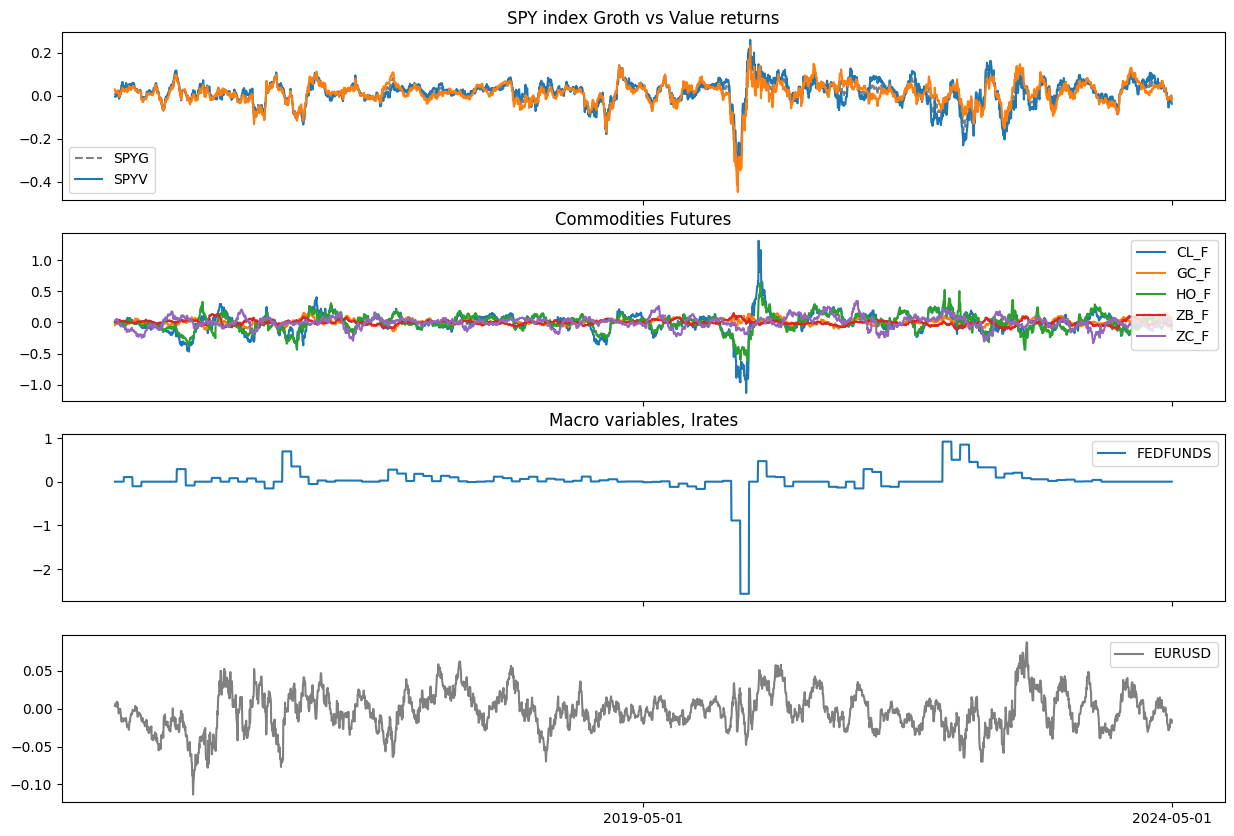

In [337]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 10), sharex=True)

#ETFs
SPYG = all_data.SPYG
SPYV = all_data.SPYV
SPY_midpoint = (SPYG + SPYV) / 2
axs[0].plot(SPY_midpoint, color="grey", linestyle="dashed")
axs[0].plot(all_data["SPYG"])
axs[0].plot(all_data["SPYV"])
axs[0].legend(["SPYG", "SPYV"])
axs[0].set_title("SPY index Groth vs Value returns")

#Commodities
for i in comm:
    axs[1].plot(all_data[i])
axs[1].legend(comm)
axs[1].set_title("Commodities Futures")

#Macro
axs[2].plot(all_data["FEDFUNDS"])
axs[2].legend(macro_df.columns)
axs[2].set_title("Macro variables, Irates")

#currencies
axs[3].plot(all_data["EURUSD"], color="grey")
axs[3].legend(curr_df.columns);

plt.xticks(ticks=all_data.index[::-int(len(all_data)/2)])
plt.savefig(os.path.join(root_dir,"charts", "all_features_history.png"))

#### _Statistical Measures_

_Correlation_

<Axes: >

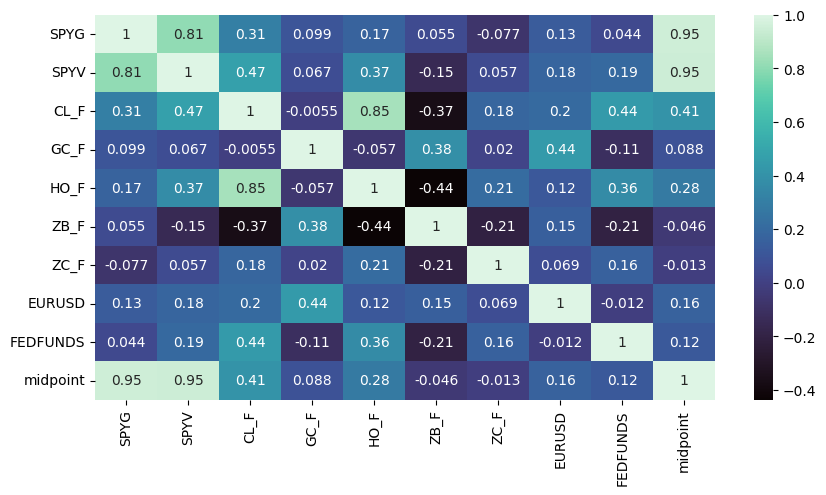

In [338]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(all_data.corr(method="pearson"),cmap="mako",annot=True)

_SPYG vs SPYV Cointegration_

In [339]:
from statsmodels.tsa.stattools import coint

SPYG = all_data.SPYG
SPYV = all_data.SPYV
t_statistic, p_val, critical_p_val = coint(SPYG, SPYV)
print(t_statistic, "\n", p_val, "\n")
alpha = 0.05
if p_val <= alpha:
    print("SPYG and SPYV are NOT cointegrated")
else:
    print("SPYG and SPYV ARE cointegrated")


-7.026254304733113 
 7.430778959474993e-09 

SPYG and SPYV are NOT cointegrated


### _Clasification of Growth/Value Moments_

In [340]:
# seperate both investing styles using the midpoint:
# 1 for growth 0 for value
period = 5
all_data["momment"] = (SPYG > SPY_midpoint).astype(int)
all_data["momment"].shift(period)
all_data.dropna(inplace=True)
y = all_data["momment"]
not_features = ["SPYG", "SPYV", "momment", "midpoint"]
features = [i for i in all_data.columns if i not in not_features]
X = all_data[features]

In [341]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

In [342]:
knn = KNeighborsClassifier(metric="cosine",n_neighbors=15,leaf_size=10)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

randomforest = RandomForestClassifier(n_estimators=1, criterion="gini")
randomforest.fit(X_train, y_train)
random_forest_predictions = randomforest.predict(X_test)

In [343]:
print(classification_report(y_test, predictions))
print(classification_report(y_test, random_forest_predictions))

              precision    recall  f1-score   support

           0       0.69      0.39      0.49       532
           1       0.59      0.84      0.69       565

    accuracy                           0.62      1097
   macro avg       0.64      0.61      0.59      1097
weighted avg       0.64      0.62      0.60      1097

              precision    recall  f1-score   support

           0       0.50      0.44      0.47       532
           1       0.52      0.58      0.55       565

    accuracy                           0.51      1097
   macro avg       0.51      0.51      0.51      1097
weighted avg       0.51      0.51      0.51      1097



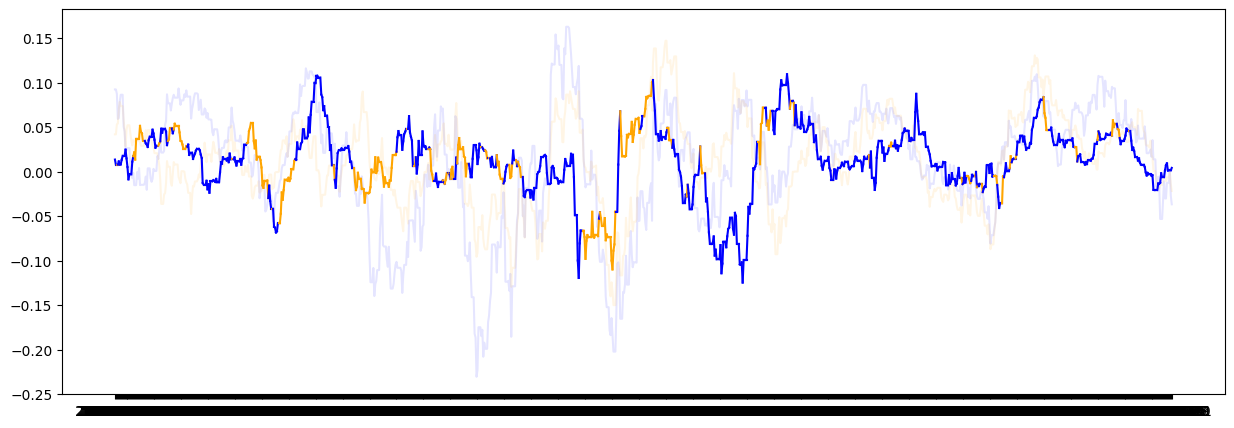

In [344]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(SPYG[y_test.index].values, color="blue", alpha=0.1)
plt.plot(SPYV[y_test.index].values, color="orange", alpha=0.1)

gidx = np.where(predictions == 1)[0]
vidx = np.where(predictions == 0)[0]

color_map = {0: "orange", 1: "blue"}
colors = [color_map[pred] for pred in predictions]
for i in range(len(predictions) - 1):
    plt.plot(y_test.index[i:i+2], SPY_midpoint[i:i+2], color=colors[i])
plt.xticks(ticks=y_test.index);

### _Backtesting with US ETFs_

In [354]:
# Calculate cumulative returns for independent assets
from tabulate import tabulate

SPYG_cret = SPYG[y_test.index].cumsum()
SPYV_cret = SPYV[y_test.index].cumsum()
STRAT_cret = []
for i in range(len(SPYG_cret)):
    if predictions[i] == 1:
        STRAT_cret.append(SPYG[y_test.index][i])
    else: 
        STRAT_cret.append(SPYV[y_test.index][i])

STRAT_cret = np.cumsum(STRAT_cret)
backtest_results = [
    ["SPYV ETF only", SPYV_cret.values[-1]], 
    ["SPYG ETF only", SPYG_cret.values[-1]],
    ["Value/Growth Momment Classification Strategy", STRAT_cret[-1]]
]

headers = ["Strategies","cumulative returns"]
print(tabulate(backtest_results, headers, tablefmt="github"))


| Strategies                                   |   cumulative returns |
|----------------------------------------------|----------------------|
| SPYV ETF only                                |              13.6798 |
| SPYG ETF only                                |              10.7669 |
| Value/Growth Momment Classification Strategy |              18.3528 |


_visualize results_

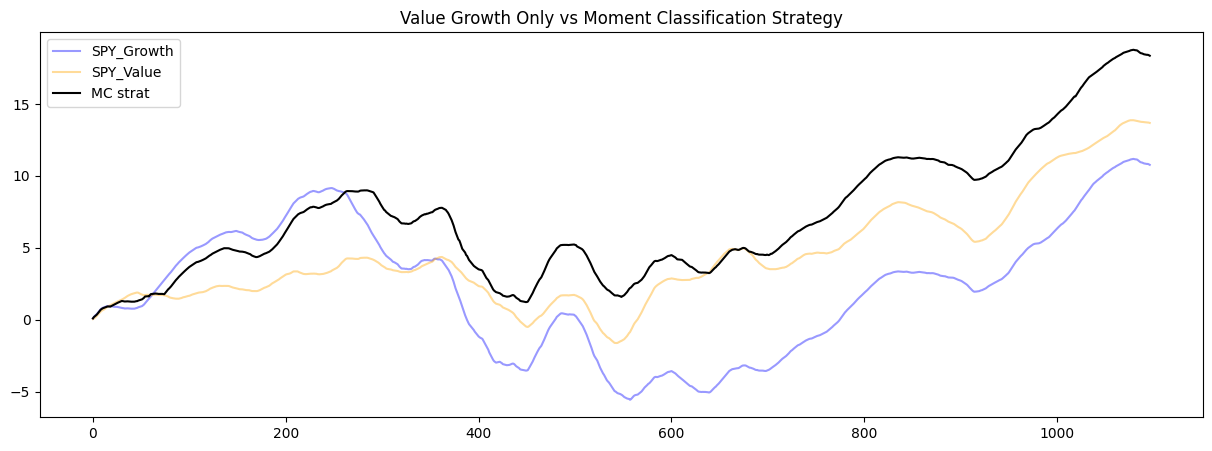

In [370]:
fig = plt.figure(figsize=(15,5))

plt.plot(SPYG_cret.values, color="blue", alpha=0.4)
plt.plot(SPYV_cret.values, color="orange", alpha=0.4)
plt.plot(STRAT_cret, color="black")
tittle = "Value Growth Only vs Moment Classification Strategy"
plt.title(tittle)
plt.legend(["SPY_Growth", "SPY_Value", "MC strat"])
plt.savefig(os.path.join(root_dir, "charts", f"{tittle.replace(" ", "_")}.png"))